In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import datetime
import json
import tensorflow as tf
from tqdm.keras import TqdmCallback

sns.set_theme()

try: # are we in Colab?
    import google.colab
    COMPUTE_ENV = 'colab'
    print('Running in Colab.')
    google.colab.drive.mount('/content/gdrive')
    OUTPUT_DIR = "/content/gdrive/My Drive/output"
    !git clone https://github.com/FriedChips/dl_basics.git
    sys.path.insert(0,'/content/dl_basics')
except: # if not...
    if "kaggle" in os.environ["PWD"]: # are we in Kaggle?
        COMPUTE_ENV = 'kaggle'
        print('Running in Kaggle.')
        !git clone https://github.com/FriedChips/dl_basics.git
        sys.path.insert(0,'../working/dl_basics')    
        OUTPUT_DIR = "./"
    else: # we're local
        COMPUTE_ENV = os.uname()[1]
        print(f"Running locally on {COMPUTE_ENV}.")
        sys.path.insert(0,'./../')
        OUTPUT_DIR = "../output/"

for gpu in tf.config.list_physical_devices("GPU"):
    print(f"Found GPU: {tf.config.experimental.get_device_details(gpu)['device_name']}.")

Running in Colab.
Mounted at /content/gdrive
Cloning into 'dl_basics'...
remote: Enumerating objects: 245, done.
remote: Counting objects: 100% (245/245), done.
remote: Compressing objects: 100% (192/192), done.
remote: Total 245 (delta 111), reused 148 (delta 52), pack-reused 0
Receiving objects: 100% (245/245), 9.36 MiB | 27.22 MiB/s, done.
Resolving deltas: 100% (111/111), done.
Found GPU: Tesla T4.


In [2]:
import models
import utils

In [3]:
(x_mnist_tr, y_mnist_tr), (x_mnist_te, y_mnist_te) = tf.keras.datasets.mnist.load_data()
#x_mnist_tr = np.expand_dims(x_mnist_tr.astype(np.float32) / 255.0, -1)
#x_mnist_te = np.expand_dims(x_mnist_te.astype(np.float32)  / 255.0, -1)
x_mnist_tr = (x_mnist_tr.astype(np.float32) / 255.0).reshape(-1, 28*28)
x_mnist_te = (x_mnist_te.astype(np.float32) / 255.0).reshape(-1, 28*28)

x_train = x_mnist_tr[:50000]
y_train = y_mnist_tr[:50000]
x_val   = x_mnist_tr[50000:]
y_val   = y_mnist_tr[50000:]

x_train.shape, y_train.shape, x_val.shape, y_val.shape

11490434/11490434 [==============================] - 0s 0us/step


((50000, 784), (50000,), (10000, 784), (10000,))

In [15]:
# init new run
P = { "training_data" : "mnist50-10" }

P["model_name"] = "mlp_01"
P["model_build_params"] = {
    "input_shape" : (28*28,),
    "layer_units" : [ 128, 10 ],
    "activations" : [ "gelu", "linear" ],
    "use_bias" : False,
    "regularizer" : "L2(0.01)"
}

model = eval("models." + P["model_name"])(**P["model_build_params"])

P["model_compile_params"] = {
    "learning_rate" : 1e-3,
    "weight_decay" : 1,
}

model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer = tf.keras.optimizers.experimental.AdamW(
        learning_rate=P["model_compile_params"]["learning_rate"],
        weight_decay=P["model_compile_params"]["weight_decay"],
    ),
    metrics = [ "accuracy" ]
)

model.summary()

P["run_dir"] = model.name + datetime.datetime.now().strftime('-%y%m%d-%H%M%S')
LOG_DIR = os.path.join(OUTPUT_DIR, P["run_dir"])

print("Log dir :", LOG_DIR)

run = utils.TrainingRun()
weight_norm_logger = utils.LogWeightNorms()
weight_logger = utils.SaveWeightsPower2(LOG_DIR)

Model: "mlp_01"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 784)]             0         
                                                                 
 dense_0 (Dense)             (None, 128)               100352    
                                                                 
 tf.nn.gelu_4 (TFOpLambda)   (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                1280      
                                                                 
Total params: 101,632
Trainable params: 101,632
Non-trainable params: 0
_________________________________________________________________
Log dir : /content/gdrive/My Drive/output/mlp_01-230415-165238


In [16]:
NUM_EPOCHS = 1024 * 1
#lr_sched = utils.Schedule_ExpCos_Segments([[-3,-3, NUM_EPOCHS]])

history = model.fit(
    x_train, y_train,
    epochs = NUM_EPOCHS,
    batch_size = 1000,
    validation_data = (x_val, y_val),
    callbacks=[
        TqdmCallback(verbose=0),
        #tf.keras.callbacks.LearningRateScheduler(lr_sched.scheduler),
        weight_norm_logger,
        weight_logger,
    ],        
    verbose=0)

run.update_history(history)

0epoch [00:00, ?epoch/s]

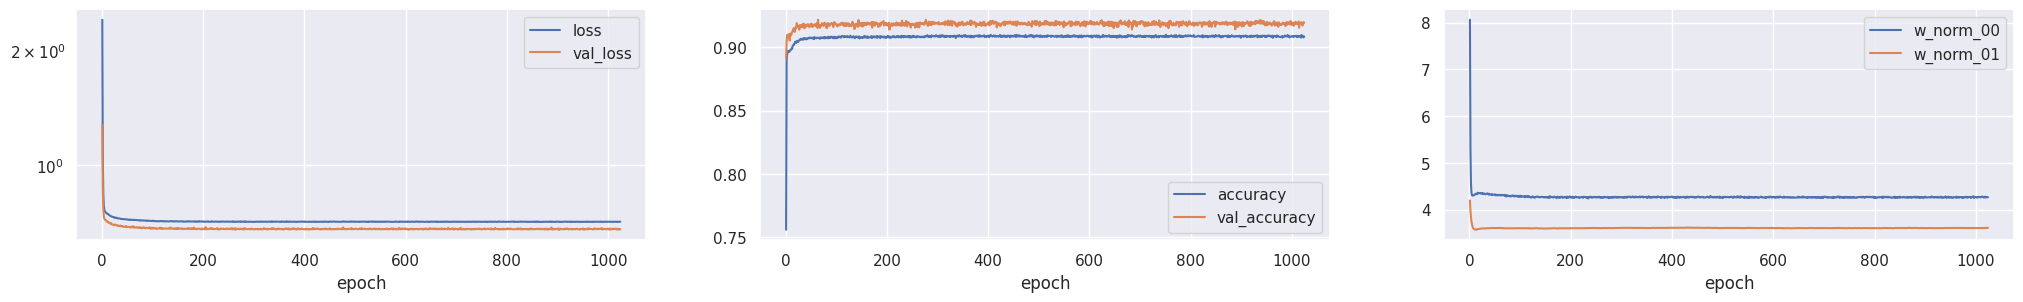

In [17]:
fig, axs = plt.subplots(1, 3, figsize=(25,3))

sns.lineplot(data=run.history[["loss", "val_loss"]], ax=axs[0], dashes=False);
axs[0].set_yscale("log");

sns.lineplot(data=run.history[["accuracy", "val_accuracy"]], ax=axs[1], dashes=False);

sns.lineplot(data=weight_norm_logger.norms_dataframe(), ax=axs[2], dashes=False);

In [18]:
run.save_state(LOG_DIR, P, model)
weight_norm_logger.norms_to_csv(LOG_DIR)

In [ ]:
#P, model = run.load_state("../output/gru_01-230407-220913")